In [3]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [2]:
from itertools import product

In [51]:
#Need to run simulation before this

def grid_search():
    # Grid search for hyperparameters
    # Returns the best hyperparameters
    grid = {
        'epsilon': [0.2, 0.3, 0.4],
        'batch_size': [64, 128, 256],
        'update_rate': [15, 30, 45],
        'learning_rate': [0.01, 0.001, 0.0001],
    }
    best_params = None
    best_reward = -math.inf
    for params in product(*grid.values()):
        hyperparameters = dict(zip(grid.keys(), params))
        reward_list, total_reward, _ = simulation(**hyperparameters)
        if total_reward > best_reward:
            best_reward = total_reward
            best_params = hyperparameters
    return best_params

best_params = grid_search()
print(best_params)

Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starti

In [44]:
runs_results, runs_totals, model = simulation()

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

In [43]:

def simulation(LAYERS = [4, 12, 12, 2], EPSILON_START = 0.2, BATCH_SIZE = 128, BUFFER_SIZE = 100000, LEARNING_RATE = 0.01, NUM_RUNS = 10, UPDATE_RATE = 15, NUM_EPISODES = 300):
    runs_results = []
    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN(LAYERS)
        target_net = DQN(LAYERS)

        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
        memory = ReplayBuffer(BUFFER_SIZE)

        steps_done = 0

        episode_durations = []

        for i_episode in range(NUM_EPISODES): 
            #EPSILON = 1
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", NUM_EPISODES)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            
            while not (done or terminated):
                #if t > 0:
                EPSILON = EPSILON_START  * (1 - i_episode/300)**2
                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < BATCH_SIZE:
                    transitions = memory.sample(BATCH_SIZE)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % UPDATE_RATE == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')

    return runs_results, np.sum(runs_results), policy_net



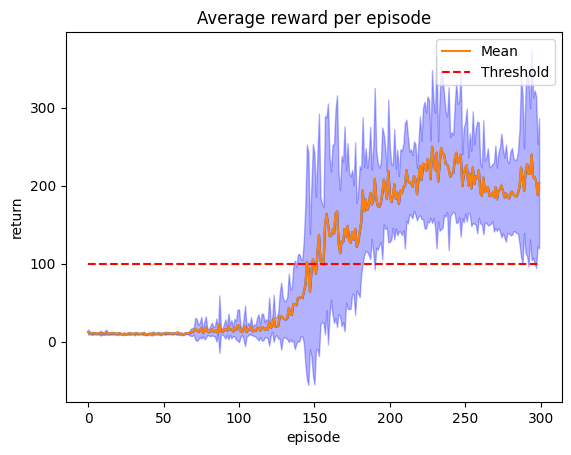

In [45]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(300), means)
plt.title("Average reward per episode")
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.plot(np.arange(300), means, label="Mean")
plt.plot(np.arange(300), np.ones(300)*100, 'r--', label="Threshold")
plt.legend()
plt.show()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2948\2676093847.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


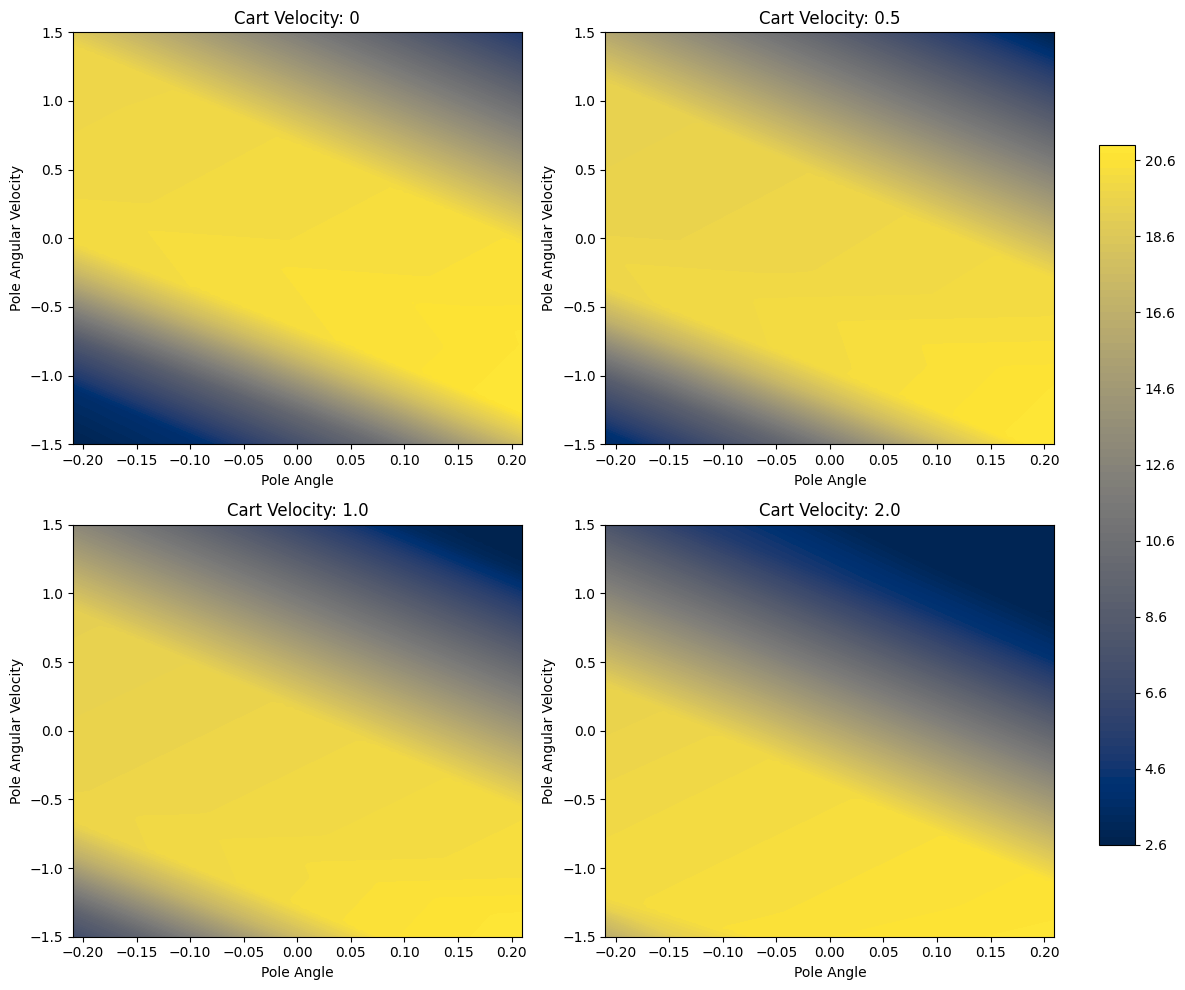

In [80]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = model   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1.5     # you may modify this range

angle_samples = 100
omega_samples = 100

# Plot for each cart velocity
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)



v_policies = []
v_q = []

velocities = [0, 0.5, 1.0, 2.0]

for v in velocities:
    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))  
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., v, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
                
    v_policies.append(policy_array)
    v_q.append(greedy_q_array)


if q:
    # Plotting Q values
    for idx, v in enumerate(velocities):
        im = axs[idx].contourf(angles, omegas, v_q[idx].T, cmap='cividis', levels=100)
        axs[idx].set_title(f'Cart Velocity: {v}')
        axs[idx].set_xlabel('Pole Angle')
        axs[idx].set_ylabel('Pole Angular Velocity')
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust these values as needed
    fig.colorbar(im, cax=cbar_ax)
else:
    # Plotting policy
    for idx, v in enumerate(velocities):
        im = axs[idx].contourf(angles, omegas, v_policies[idx].T, cmap='cividis', levels=100)
        axs[idx].set_title(f'Cart Velocity: {v}')
        axs[idx].set_xlabel('Pole Angle')
        axs[idx].set_ylabel('Pole Angular Velocity')
        # Adding a colorbar to explain the color scheme
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust these values as needed
    fig.colorbar(im, cax=cbar_ax)




plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()